# Four Color Theorem using SAT

In this notebook, we will illustrate the four color theorem using SAT solvers.

The first few blocks of code will install and import the necessary libraries and load the necessary data. This notebook uses a reduced version of the [Natural Earth Data](https://www.naturalearthdata.com/downloads/110m-cultural-vectors/110m-admin-0-countries/).

If you are working inside a conda environement, you should probably run this line as a preliminary step.

In [1]:
# ONLY IF YOU ARE WORKING IN A CONDA ENVIRONEMENT
%conda install pyproj

ValueError: The python kernel does not appear to be a conda environment.  Please use ``%pip install`` instead.

In [3]:
%pip install matplotlib python-sat pandas geopandas

Note: you may need to restart the kernel to use updated packages.


In [4]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from pysat.solvers import Glucose3
import pandas as pd
import geopandas as gpd

## Part 1: Colouring the map of Europe

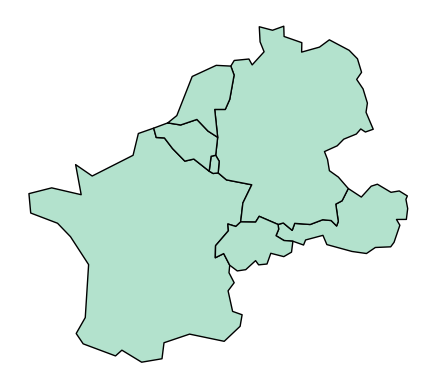

In [5]:
small_map = gpd.read_file("smaller_map/smaller_map.shp")[["NAME", "geometry"]].assign(COLOR=0)

k = 4 # number of colors
N = small_map.shape[0] # number of countries

def show_map(data, ax):
    ax.axis("off")
    data.plot(column = "COLOR", cmap="Pastel2", edgecolor="black", ax=ax)

fig, ax = plt.subplots(1,1)
show_map(small_map, ax)

NEIGHBORS = [
    [2, 3, 4, 5], # 0 France
    [2, 3], # 1 Austria
    [0, 1, 3, 4, 5, 6], # 2 Germany
    [0, 1, 2], # 3 Switzerland
    [0, 2, 5], # 4 Luxembourg
    [0, 2, 4, 6], # 5 Belgium
    [2, 5] # 6 Netherlands
]



### Creating the variables (and the SAT solver)

To use our SAT solver, we will need to create the variables used to describe the solution.

Like in the DIMACS file format, variables are simply strictly positive integers that each represent a different variable

Like in the course material, we will use variable `p[i][j]` that will represent that country $i$ has color $j$ (and since we are in Python, $i$ and $j$ will start at $0$)

In [6]:
# helper function to create unique variables
VARIABLE_COUNT = 0
def getNewVariable():
    global VARIABLE_COUNT
    VARIABLE_COUNT += 1
    return VARIABLE_COUNT

# Create the SAT solver instance
solver = Glucose3() 

# Create our array of variables
VARIABLES = [[getNewVariable() for j in range(k)] for i in range(N)]

### First contraint : Each country has one color

We have to make sure that each country has exactly one color. This done by creating a clause so that each country has **at least** one color and then clauses so that each country has **at most** one color

#### At least 1 color

This is done by first adding a clause for each country of the form

$$p_{i,0} \lor \ldots \lor p_{i,k-1}$$

Indeed, to make this clause true, it suffises that one $p_{i,j}$ is true.

#### At most 1 color

This is done by adding the following clauses for each country $i$ and for each pair of different colors $(j_1, j_2)$ 

$$\lnot p_{i, j_1} \lor \lnot p_{i, j_2}$$

Indeed, to make all these clauses true, we need at least $k-1$ variables to be set to false. This ensures that at most $1$ is true.

#### Encoding these clauses 

To add clauses to our solver, one needs to use the `add_clause` method. This method requires a list of variables, and will add a clause using the given variables. If you wish to use the negated variable inside the clause, you need to negate it in the list

E.g. to encode $\lnot p_{1, 1} \lor p_{2, 2}$ you have to use `solver.add_clause([ -p[1][1], p[2][2] ])`

In [11]:
def exactly_one_color_for_each_country(solver, variables, N, k):
    for i in range(N):
        solver.add_clause(variables[i])
    return
        

# (Incomplete) Test to see if the encoding is correct

exactly_one_color_for_each_country(solver, VARIABLES, N, k)
result = solver.solve([VARIABLES[0][0], VARIABLES[0][1]])
if result == True:
    print("Your clauses are not correct, as we assumed that the first country has color 0 and color 1")
    print("To retry new clauses, make sure to rerun the previous cell")
elif result == None:
    print("There is a problem with the solver")

Your clauses are not correct, as we assumed that the first country has color 0 and color 1
To retry new clauses, make sure to rerun the previous cell


If we were to ask the SAT solver for a model right now, we would not have a sensible solution, as we did not encode the borders inside our model yet.

### Second constraint : different colors for bordering countries

To encode this we will add clauses for each color $j$, that indicates that neighboring countries ($i_1, i_2$) cannot both have color $j$. These clauses will look like

$$\lnot p_{i_1, j} \lor \lnot p_{i_2, j}$$

In [12]:
def different_colors_for_bordering_countries(solver, variables, N, k, neighbors):
    for i in range(N):
        for n in NEIGHBORS[i]:
            for j in range(k):
                solver.add_clause([-variables[i][j], - variables[n][j]])
    return

# (Incomplete) Test to see if the contraints are correct
different_colors_for_bordering_countries(solver, VARIABLES, N, k, NEIGHBORS)

result = solver.solve([VARIABLES[0][0], VARIABLES[2][0]])
if result == True:
    print("Your clauses are not correct, as we assumed that the 2 neighbouring countries had the same color")
    print("To retry new clauses, make sure to rerun the two previous cells")
elif result == None:
    print("There is a problem with the solver")

Now all the necessary clauses are set, we can ask the SAT solver to find a model (if one exists).

In [13]:
result = solver.solve()

if result == True:
    print("There is a solution")
elif result == False:
    print("There is no solution")
else:
    print("There was an error during the solve")

There is a solution


If all went correctly, there should be a solution (unless the theorem that was proven true is wrong).

### The resulting coloring

Since there is a solution, we can ask the solver to give us a model, and draw the map with different colors.

,NAME,COLOR
0,France,0
1,Austria,0
2,Germany,2
3,Switzerland,1
4,Luxembourg,1
5,Belgium,3
6,Netherlands,0


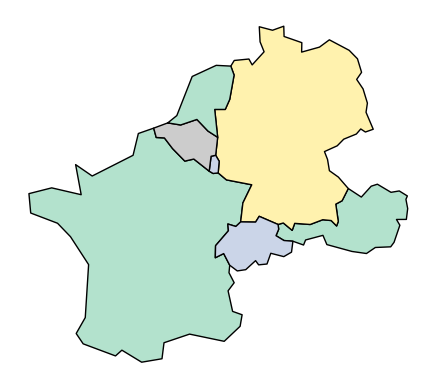

In [15]:
model = solver.get_model()

for i in range(N):
    for j in range(k):
        if model[ VARIABLES[i][j] -1] > 0: #if variable p[i][j] is True in this model/interpretation
            small_map.at[i, "COLOR"] = j

fig, ax = plt.subplots(1,1)

show_map(small_map, ax)

small_map[["NAME", "COLOR"]]

As you can see, we have colored the map using 4 colors such that each neighboring country do not have the same color.

### Small Bonus : keep France green

How would you make sure that France ($i = 0$) keeps the original green color ($j = 0$)?

Try to force some other colors and see if the SAT solver can still find a solution.

          NAME  COLOR
0       France      0
1      Austria      0
2      Germany      2
3  Switzerland      1
4   Luxembourg      1
5      Belgium      3
6  Netherlands      0


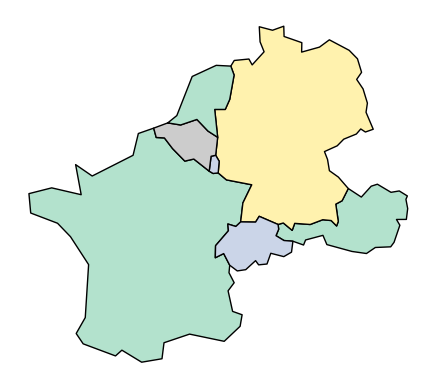

In [16]:
# YOUR CODE HERE

# Do not modify
result = solver.solve()
if result == True:
    model = solver.get_model()

    for i in range(N):
        for j in range(k):
            if model[ VARIABLES[i][j] -1] > 0: #if variable p[i][j] is True in this model/interpretation
                small_map.at[i, "COLOR"] = j

    fig, ax = plt.subplots(1,1)

    show_map(small_map, ax)
    print(small_map[["NAME", "COLOR"]])
else:
    print("No solution")

## Part 2: a counter-example to MacGregor theorem?
MacGregor theorem (aka four colors theorem) states that any map can be colored with 4 colors. In 1975, Martin Gardner claimed that he found a counter-example to this theorem. The cell below plots his counter-example.

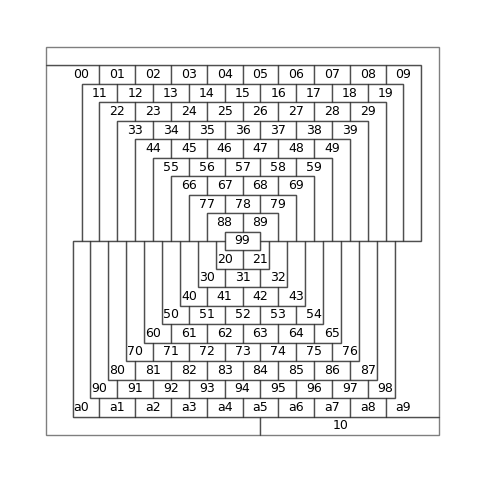

In [17]:
# DO NOT MODIFY

# Dictionnary of colors
COLOR_CODE = {
    0: 'red',
    1: 'cyan',
    2: 'pink',
    3: 'purple',
    -1: 'white'
}

# Function to read zones, labels and add colors into DataFrames
def read_zones_from_csv(filename):
    data = pd.read_csv(filename, dtype={'Label': str})

    vertices = data[data['Type'] == 'vertex'].copy()
    labels = data[data['Type'] == 'label'].copy()

    vertices_grouped = (
        vertices.groupby('ZoneID')[['X', 'Y']]
        .apply(lambda group: list(zip(group['X'], group['Y']))) # Make list of tuples (X,Y)
        .reset_index(name='Vertices')
    )

    vertices_grouped['Color'] = COLOR_CODE[-1]  # Default color is white (not considered as one of the four colors)

    labels = labels.rename(columns={'X': 'LabelX', 'Y': 'LabelY'})
    zones_df = pd.merge(vertices_grouped, labels[['ZoneID', 'LabelX', 'LabelY', 'Label']],
                        on='ZoneID', how='left')

    return zones_df

# Function to draw zones with specific labels and colors
def draw_zones_with_labels(zones_df):
    fig, ax = plt.subplots(figsize=(6, 6))

    # Draw each zone
    for _, row in zones_df.iterrows():
        polygon = Polygon(row['Vertices'], closed=True, fill=True, alpha=0.5, edgecolor='black')
        polygon.set_facecolor(row['Color']) # Add color
        ax.add_patch(polygon)

        if not pd.isna(row['Label']):
            ax.text(row['LabelX'], row['LabelY'], row['Label'], fontsize=9,
                    ha='center', va='center', color='black') # Add label
    
    ax.set_xlim(-20, 240)
    ax.set_ylim(-20, 230)
    ax.axis('off')
    plt.show()

filename = 'zones.csv'
zones_df = read_zones_from_csv(filename)
draw_zones_with_labels(zones_df)


Let us check whether this map is indeed a counter-example fo the theorem. We proceed in the same way as for the map of Europe. We create the SAT solver, the variables and we encode the constraints: exactly one color for each country and different colors for bordering countries.

In [18]:
# DO NOT MODIFY
import adjacent_zones as az

N = len(zones_df) # Number of zones
k = 4 # Number of colors

# Create the SAT solver instance
solver = Glucose3() 

# Create our array of variables
VARIABLE_COUNT = 0
VARIABLES = [[getNewVariable() for j in range(k)] for i in range(N)]

# List of the set of adjacent zones
NEIGHBORS = az.get_adjacent_zones()

exactly_one_color_for_each_country(solver, VARIABLES, N, k)
different_colors_for_bordering_countries(solver, VARIABLES, N, k, NEIGHBORS)

We now check whether the map of Martin Gardner is indeed a counter-example.

In [19]:
# DO NOT MODIFY

solution = solver.solve()

if solution == False:
    print("The provided counter-example is valid!")
elif solution == True:
    print("There is a solution, so the counter-example is not valid!")
else:
    print("Solver encountered an issue.")

There is a solution, so the counter-example is not valid!


Since there is a solution, the counter-example of Martin Gardner is wrong. The theorem has been proven correct in 2005, hence such a counter-example does not exist! The cell below plots the coloring of the map proposed by Martin Gardner (there might exist other solutions).

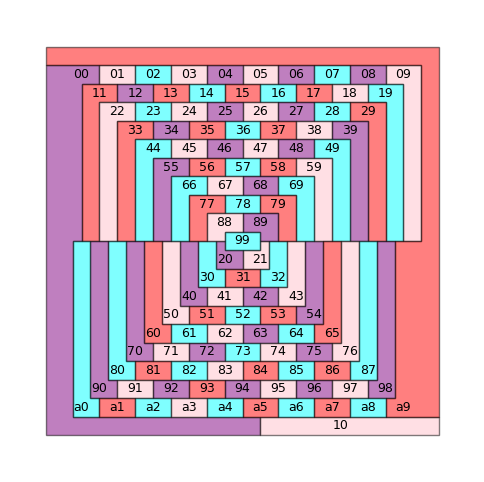

In [20]:
# DO NOT MODIFY

model = solver.get_model() # Get the model that satisfies the clauses
for i in range(N):
    for j in range(k):
        if model[VARIABLES[i][j] - 1] > 0: # If proposition p[i][j] is True
            zones_df.at[i, 'Color'] = COLOR_CODE[j] # Zone i has the color j

draw_zones_with_labels(zones_df)

### Bonus: how to generate other solutions?
Try to generate other colorings of this map. Hint: you can repeatedly compute a new model, by constraining the solver to never compute a model already seen before.

New solution: 


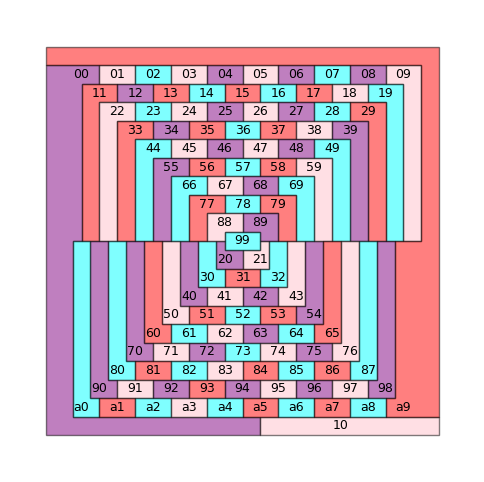

In [21]:
solver.solve()
model = solver.get_model()

# YOUR CODE HERE

solver.solve()
model2 = solver.get_model()

print("New solution: ")
for i in range(N):
    for j in range(k):
        if model2[VARIABLES[i][j] - 1] > 0: # If proposition p[i][j] is True
            zones_df.at[i, 'Color'] = COLOR_CODE[j] # Zone i has the color j

draw_zones_with_labels(zones_df)
for i in range(N):
    for j in range(k):
        if model[VARIABLES[i][j] - 1] != model2[VARIABLES[i][j] - 1]:
            print("The models differ for zone " + str(i))
            break